# Prequisites

* https://pytorchvideo.org/docs/tutorial_torchhub_inference
* pip install "numpy<2" --upgrade
* PyTorchVideo has compatibility issues with latest versions of PyTorch and Torchvision
* Replace "import torchvision.transforms.functional_tensor as F_t" with  __import torchvision.transforms.functional as F_t__ 

In [2]:
import torch
import json
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    Normalize,
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from typing import Dict
import cv2 
from pathlib import Path

from ultralytics import YOLO
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from boxmot import BoostTrack
from boxmot import StrongSort
import numpy as np
import torch

from collections import defaultdict
import os

c:\Users\Snowwolf\miniconda3\envs\slowfast\lib\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
c:\Users\Snowwolf\miniconda3\envs\slowfast\lib\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


# Video Classification Model

In [4]:
# Device on which to run the model
# Set to cuda to load on GPU
device = "cpu"

# Pick a pretrained model and load the pretrained weights
model_name = "slowfast_r50"
video_model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=True)

# Set to eval mode and move to desired device
video_model = video_model.to(device)
video_model = video_model.eval()

Using cache found in C:\Users\Snowwolf/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [5]:
transform = Compose([
    Lambda(lambda x: x / 255.0),  # scale to [0,1]
    Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
    ShortSideScale(256),
    CenterCropVideo(256),
])

In [6]:
class PackPathway:
    def __call__(self, frames: torch.Tensor):
        fast_pathway = frames
        # take 1 of every 4 frames for slow pathway
        slow_pathway = torch.index_select(
            frames, 1, torch.linspace(0, frames.shape[1]-1, frames.shape[1]//4).long()
        )
        return [slow_pathway, fast_pathway]

pack_pathway = PackPathway()

#slow_pathway length = fast_pathway length / 4

In [7]:
def run_action_recognition(track_buffer):
    # track_buffer = list of 32 RGB frames (H,W,3), dtype=uint8
    clip = np.stack(track_buffer)  # [T, H, W, 3]
    clip = torch.from_numpy(clip).permute(3,0,1,2)  # [C, T, H, W]

    # apply transform (resize, normalize, crop)
    clip = transform(clip)

    # add batch dim
    clip = clip.unsqueeze(0).float()

    # pack for slowfast
    inputs = pack_pathway(clip[0])  # remove batch for PackPathway
    inputs = [i.unsqueeze(0) for i in inputs]  # add back batch

    # inference
    with torch.no_grad():
        preds = video_model(inputs)
    
    return preds

# Labels

In [ ]:
# !curl -L -o kinetics_classnames.json https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json

In [9]:
with open("kinetics_classnames.json", "r") as file:
    data = json.load(file)

classes = {}
for action, label in data.items():
    classes[label] = action 

classes[32]

'"braiding hair"'

# Detector Model 

In [10]:
detector_model = YOLO("yolo11s.pt")

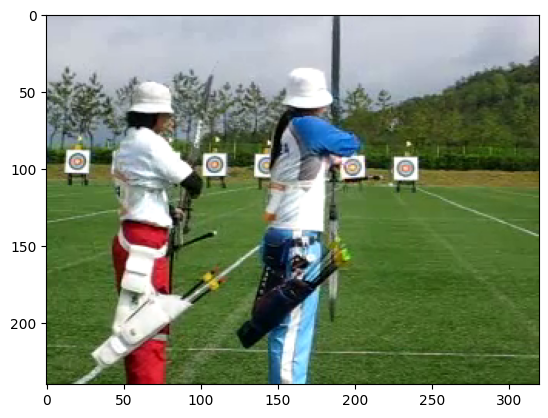

In [11]:
img = cv2.imread("snap1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [12]:
results = detector_model.predict(img, device="cuda")


0: 480x640 2 persons, 1 baseball bat, 64.4ms
Speed: 2.7ms preprocess, 64.4ms inference, 110.8ms postprocess per image at shape (1, 3, 480, 640)


https://docs.ultralytics.com/modes/predict/#real-world-applications

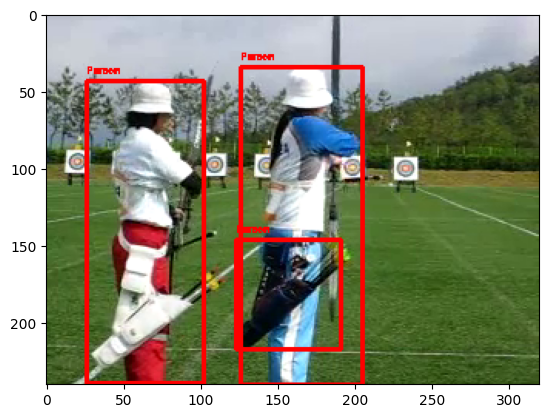

In [13]:
temp = img.copy()

for result in results:
    pass
length = len(result.boxes.data)
for index in range(length):
    boxes = result.boxes
    xyxy = boxes.xyxy[index].detach().cpu()
    x1, y1, x2, y2 = int(xyxy[0].item()), int(xyxy[1].item()), int(xyxy[2].item()), int(xyxy[3].item())
    # xywh = boxes.xywh[0].detach().cpu()
    # x1, y1, w, h = int(xywh[0].item()), int(xywh[1].item()), int(xywh[2].item()), int(xywh[3].item())
    cls_id = int(result.boxes.cls[index].detach().cpu().item())
    confidence = int(result.boxes.conf[index].detach().cpu().item())
    cv2.rectangle(temp, (x1, y1), (x2, y2), (255,0,0), 2)
    cv2.putText(temp, text="Person", org=(x1, y1-5), color=(255,0,0), fontScale=0.2, fontFace=cv2.FONT_HERSHEY_DUPLEX)


plt.imshow(temp)

In [15]:
def object_detection(img):
    lis = []
    results = detector_model.predict(img, verbose=False, device="cuda")
    temp = img.copy()
    for result in results:
        pass
    length = len(result.boxes.data)
    for index in range(length):
        boxes = result.boxes
        xyxy = boxes.xyxy[index].detach().cpu()
        x1, y1, x2, y2 = int(xyxy[0].item()), int(xyxy[1].item()), int(xyxy[2].item()), int(xyxy[3].item())
        # xywh = boxes.xywh[0].detach().cpu()
        # x1, y1, w, h = int(xywh[0].item()), int(xywh[1].item()), int(xywh[2].item()), int(xywh[3].item())
        cls_id = int(result.boxes.cls[index].detach().cpu().item())
        if(cls_id != 0): #Only person detection trying
            continue
        confidence = float(result.boxes.conf[index].detach().cpu().item())
        cv2.rectangle(temp, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(temp, text="Person", org=(x1, y1-5), color=(255,0,0), fontScale=0.2, fontFace=cv2.FONT_HERSHEY_DUPLEX)
        res = [x1, y1, x2, y2, confidence, cls_id]
        lis.append(res)
    return lis


# Tracking Model

In [16]:
if torch.cuda.is_available():
    # device = torch.device("cuda")
    device = "cuda"
else:
    device = torch.device("cpu")

#tracker = BoostTrack(reid_weights='osnet_x0_25_msmt17.pt', device=device, half=False)

tracker = StrongSort(reid_weights=Path("osnet_x0_25_market1501.pt"), device="cpu", half=False)

2025-10-03 02:02:07.321 | INFO     | boxmot.trackers.basetracker:__init__:56 - BaseTracker initialization parameters:
2025-10-03 02:02:07.322 | INFO     | boxmot.trackers.basetracker:__init__:57 - det_thresh: 0.3
2025-10-03 02:02:07.323 | INFO     | boxmot.trackers.basetracker:__init__:58 - max_age: 30
2025-10-03 02:02:07.323 | INFO     | boxmot.trackers.basetracker:__init__:59 - max_obs: 50
2025-10-03 02:02:07.323 | INFO     | boxmot.trackers.basetracker:__init__:60 - min_hits: 3
2025-10-03 02:02:07.324 | INFO     | boxmot.trackers.basetracker:__init__:61 - iou_threshold: 0.3
2025-10-03 02:02:07.324 | INFO     | boxmot.trackers.basetracker:__init__:62 - per_class: False
2025-10-03 02:02:07.324 | INFO     | boxmot.trackers.basetracker:__init__:63 - nr_classes: 80
2025-10-03 02:02:07.325 | INFO     | boxmot.trackers.basetracker:__init__:64 - asso_func: iou
2025-10-03 02:02:07.325 | INFO     | boxmot.trackers.basetracker:__init__:65 - is_obb: False
2025-10-03 02:02:07.326 | INFO     | bo

In [17]:
def visualize_tracking(tracker_results, img):
    for i in tracker_results:
        x1, y1, x2, y2 = int(i[0]), int(i[1]), int(i[2]), int(i[3])
        track_id = int(i[4])
        track_confidence = float(i[5])
        cv2.rectangle(img, (x1,y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, text=str(track_id), org=(x1, y1-5), color=(255,0,0), fontScale=0.2, fontFace=cv2.FONT_HERSHEY_DUPLEX)
    return img 

In [18]:
def save_video_clip(track__buffers, out_path, track_id):
    h, w, _ = track__buffers[track_id][0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, 15, (w, h))
    for f in track__buffers[track_id]:
        out.write(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
    out.release()

# Video Inferencing Cropped (With Tracker)

In [19]:
path = "video1.mp4"
cap = cv2.VideoCapture(path)

In [20]:
track__buffers = defaultdict(list)
save_dir = "clips"
frame_idx = 0
labels = ["X", "X"]

while True:
    success, frame = cap.read()
    if not success:
        print("Video ended")
        break 
    frame_idx += 1
    if(frame_idx % 3 != 0):
        continue
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    copy_frame = frame.copy()
    detections = np.array(object_detection(frame))
    tracker_results = tracker.update(detections, frame)
    #print(tracker_results)
    #annotated_img = visualize_tracking(tracker_results, frame)
    #Cropping separately as per id
    for x1,y1,x2,y2, track_id, conf, cls_id, frame_id in tracker_results:
        x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
        crop = copy_frame[y1:y2, x1:x2]
        crop = cv2.resize(crop, (256, 256))
        track__buffers[track_id].append(crop)
        cv2.rectangle(frame, (x1,y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, text=str(track_id), org=(x1, y1-5), color=(255,0,0), fontScale=0.2, fontFace=cv2.FONT_HERSHEY_DUPLEX)
        cv2.putText(frame, text=str(labels[0:2]), org=(x1+15, y1-5), color=(255,0,0), fontScale=0.15, fontFace=cv2.FONT_HERSHEY_DUPLEX)

        if len(track__buffers[track_id]) == 32:
            out_path = os.path.join(save_dir, f"id_{int(track_id)}_frame_{int(frame_idx)}.mp4")
            #save_video_clip(track__buffers, out_path, track_id)
            preds = run_action_recognition(track__buffers[track_id])
            preds = torch.nn.Softmax(dim=1)(preds)
            topk = torch.topk(preds, k=5)
            track__buffers[track_id] = []
            labels = [classes[i.item()] for i in topk.indices[0]]
            scores = [topk.values[0][i].item() for i in range(5)]
            #cv2.rectangle(frame, (x1,y1), (x2, y2), (255, 0, 0), 2)
            #cv2.putText(frame, text=str(track_id), org=(x1, y1-5), color=(255,0,0), fontScale=0.2, fontFace=cv2.FONT_HERSHEY_DUPLEX)
            #cv2.putText(frame, text=labels[0:2], org=(x1+15, y1-5), color=(255,0,0), fontScale=0.15, fontFace=cv2.FONT_HERSHEY_DUPLEX)
            #print(f"For frame {frame_idx} The classes are : {labels[0:2]}")

    
    cv2.imshow("Tracker_frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Video ended
